#  CNN Cancer Detection Kaggle Mini-Project

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

In [3]:
# Libraries
import numpy as np
import pandas as pd
import os
from PIL import Image
import io
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pretrainedmodels
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import torchvision.transforms as T

In [4]:
# Compression transform
class JPEGCompression:
    def __init__(self, quality_range=(80, 100)):
        self.quality_range = quality_range

    def __call__(self, img):
        quality = random.randint(self.quality_range[0], self.quality_range[1])
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=quality)
        buffer.seek(0)
        return Image.open(buffer).convert("RGB")

# Training transformations with augmentation
data_transforms_resnet = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
    T.RandomAffine(degrees=15, scale=(0.9, 1.1)),
    T.RandomApply([JPEGCompression(quality_range=(80, 100))], p=0.5),
    T.RandomApply([T.ColorJitter(hue=0.1, saturation=0.1)], p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test transformations (no augmentation)
data_transforms_test_resnet = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:

class CancerDataset(Dataset):
    def __init__(self, datafolder, indices, transform=None, labels_dict=None, datatype='train'):
        self.datafolder = datafolder
        self.indices = indices
        self.transform = transform
        self.labels_dict = labels_dict
        self.datatype = datatype
        if self.datatype == 'train':
            self.image_files = labels.iloc[indices]['id'].values
        else:
            self.image_files = os.listdir(datafolder)

    def __len__(self):
        return len(self.indices) if self.datatype == 'train' else len(self.image_files)

    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_id = self.image_files[idx]
            img_name = f"{img_id}.tif"
            label = self.labels_dict.get(img_id, 0)
        else:
            img_name = self.image_files[idx]
            label = 0  # Placeholder label for test data

        img_path = os.path.join(self.datafolder, img_name)
        try:
            image = Image.open(img_path).convert('RGB')  # Load and ensure RGB format
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black PIL Image in case of error
            image = Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label

Total training samples: 220025
220025 pictures in train.
57458 pictures in test.


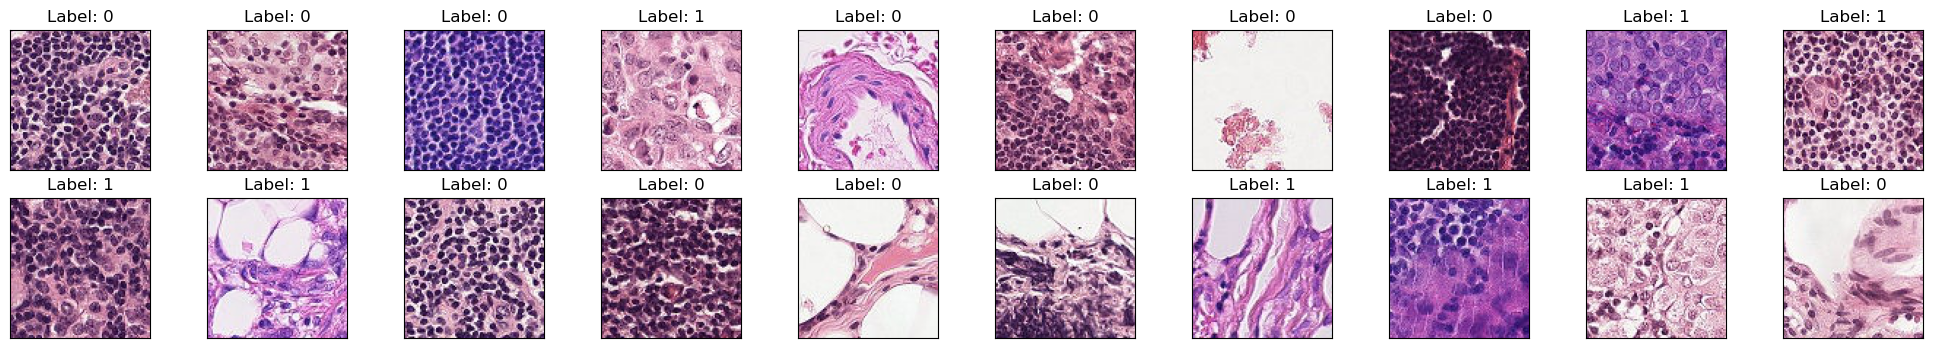

Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Training samples: 198022
Validation samples: 22003


In [6]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision.transforms as T

# Define paths
base_dir = r"C:\Users\User\Desktop\Cancer Detection Deep Learning"
labels_path = os.path.join(base_dir, "train_labels.csv")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Load train labels
labels = pd.read_csv(labels_path)
print(f'Total training samples: {len(labels)}')

# Verify image counts
print(f'{len(os.listdir(train_dir))} pictures in train.')
print(f'{len(os.listdir(test_dir))} pictures in test.')

# Visualize sample images
num_samples = 20
sample_images = np.random.choice(os.listdir(train_dir), num_samples, replace=False)

fig = plt.figure(figsize=(25, 4))

for idx, img in enumerate(sample_images):
    ax = fig.add_subplot(2, num_samples//2, idx+1, xticks=[], yticks=[])
    img_path = os.path.join(train_dir, img)
    image = Image.open(img_path).convert('RGB')
    plt.imshow(image)
    img_id = img.split('.')[0]
    label = labels.loc[labels['id'] == img_id, 'label'].values[0]
    ax.set_title(f'Label: {label}')

plt.show()

# Check label distribution
print("Label distribution:")
print(labels['label'].value_counts())

# Split data into training and validation sets
test_size = 0.1
random_state = 42

train_indices, val_indices = train_test_split(
    labels.index,
    test_size=test_size,
    stratify=labels['label'],
    random_state=random_state
)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")

# Create a dictionary mapping image IDs to labels
img_class_dict = {row['id']: row['label'] for _, row in labels.iterrows()}

# Define transforms (from previous response)
class JPEGCompression:
    def __init__(self, quality_range=(80, 100)):
        self.quality_range = quality_range

    def __call__(self, img):
        quality = random.randint(self.quality_range[0], self.quality_range[1])
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=quality)
        buffer.seek(0)
        return Image.open(buffer).convert("RGB")

data_transforms_resnet = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
    T.RandomAffine(degrees=15, scale=(0.9, 1.1)),
    T.RandomApply([JPEGCompression(quality_range=(80, 100))], p=0.5),
    T.RandomApply([T.ColorJitter(hue=0.1, saturation=0.1)], p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_transforms_test_resnet = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create training and validation datasets
train_dataset_resnet = CancerDataset(
    datafolder=train_dir,
    indices=train_indices,
    transform=data_transforms_resnet,
    labels_dict=img_class_dict,
    datatype='train'
)

val_dataset_resnet = CancerDataset(
    datafolder=train_dir,
    indices=val_indices,
    transform=data_transforms_test_resnet,
    labels_dict=img_class_dict,
    datatype='train'
)

# Define batch size and number of workers
batch_size_resnet = 32
num_workers = 4  # Adjust based on your system

# Create DataLoaders
train_loader_resnet = DataLoader(
    train_dataset_resnet,
    batch_size=batch_size_resnet,
    shuffle=True,
    num_workers=num_workers
)

valid_loader_resnet = DataLoader(
    val_dataset_resnet,
    batch_size=batch_size_resnet,
    shuffle=False,
    num_workers=num_workers
)

# Test data
test_dataset_resnet = CancerDataset(
    datafolder=test_dir,
    indices=None,  # Not used for test
    transform=data_transforms_test_resnet,
    labels_dict=None,
    datatype='test'
)

test_loader_resnet = DataLoader(
    test_dataset_resnet,
    batch_size=batch_size_resnet,
    shuffle=False,
    num_workers=num_workers
)

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

# Load the pretrained ResNet50 model
model_resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 1)  # Binary classification

# Initialize the new layer's weights
nn.init.kaiming_normal_(model_resnet.fc.weight, mode='fan_out', nonlinearity='relu')
nn.init.zeros_(model_resnet.fc.bias)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Define the loss function
criterion_resnet = nn.BCEWithLogitsLoss()

# Define the optimizer (only the final layer's parameters)
optimizer_resnet = optim.AdamW(model_resnet.fc.parameters(), lr=0.005, weight_decay=1e-4)

# Define the learning rate scheduler
scheduler_resnet = CosineAnnealingLR(optimizer_resnet, T_max=10, eta_min=1e-6)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast

# Model setup
model_resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 1)
nn.init.kaiming_normal_(model_resnet.fc.weight, mode='fan_out', nonlinearity='relu')
nn.init.zeros_(model_resnet.fc.bias)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

criterion_resnet = nn.BCEWithLogitsLoss()
optimizer_resnet = optim.AdamW(model_resnet.fc.parameters(), lr=0.005, weight_decay=1e-4)
scheduler_resnet = CosineAnnealingLR(optimizer_resnet, T_max=10, eta_min=1e-6)
scaler = GradScaler()

# Training parameters
n_epochs_resnet = 3
valid_loss_min_resnet = np.Inf
patience_resnet = 7
p_resnet = 0

for epoch in range(1, n_epochs_resnet + 1):
    torch.cuda.empty_cache()
    start_time = time.time()
    print(f'\nEpoch {epoch}/{n_epochs_resnet}')
    print('-' * 30)

    model_resnet.train()
    train_loss = []
    train_preds_all = []
    train_targets_all = []

    for data, target in tqdm(train_loader_resnet, desc='Training', leave=False):
        data, target = data.to(device), target.float().to(device).unsqueeze(1)

        optimizer_resnet.zero_grad()
        with autocast():
            output = model_resnet(data)
            loss = criterion_resnet(output, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer_resnet)
        scaler.update()

        train_loss.append(loss.item())
        preds = torch.sigmoid(output).detach().cpu().numpy()
        targets = target.detach().cpu().numpy()
        train_preds_all.extend(preds)
        train_targets_all.extend(targets)

    train_loss_avg = np.mean(train_loss)
    train_auc_avg = roc_auc_score(train_targets_all, train_preds_all)

    model_resnet.eval()
    val_loss = []
    val_preds_all = []
    val_targets_all = []

    with torch.no_grad():
        for data, target in tqdm(valid_loader_resnet, desc='Validation', leave=False):
            data, target = data.to(device), target.float().to(device).unsqueeze(1)
            with autocast():
                output = model_resnet(data)
                loss = criterion_resnet(output, target)
            val_loss.append(loss.item())
            preds = torch.sigmoid(output).detach().cpu().numpy()
            targets = target.detach().cpu().numpy()
            val_preds_all.extend(preds)
            val_targets_all.extend(targets)

    val_loss_avg = np.mean(val_loss)
    val_auc_avg = roc_auc_score(val_targets_all, val_preds_all)

    print(f'Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}')
    print(f'Train AUC: {train_auc_avg:.4f} | Val AUC: {val_auc_avg:.4f}')
    print(f"Epoch {epoch} completed in {(time.time() - start_time)/60:.2f} minutes")

    if val_loss_avg < valid_loss_min_resnet:
        print(f'Validation loss decreased ({valid_loss_min_resnet:.6f} --> {val_loss_avg:.6f}). Saving model...')
        torch.save(model_resnet.state_dict(), 'model_resnet.pt')
        valid_loss_min_resnet = val_loss_avg
        p_resnet = 0
    else:
        p_resnet += 1
        print(f'{p_resnet} epochs of no improvement.')
        if p_resnet > patience_resnet:
            print('Early stopping triggered.')
            break

    scheduler_resnet.step()




Epoch 1/3
------------------------------


Training:   0%|                                                                               | 0/6189 [00:00<?, ?it/s]